# **Intel iamge classifcation using keras**
# **Anas Ba Ragaa**


**This f is divided to two parts without preprocessing **

Dataset : https://www.kaggle.com/puneet6060/intel-image-classification

# **Preprocessing and utils**

In [1]:
# This code was executed inside Kaggle nootbook
!pip install matplotlip
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.densenet import DenseNet169
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
#from keras.applications import EfficientNetB3
from keras.callbacks import ModelCheckpoint
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle           
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from IPython.display import display
from keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import models, layers
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report

print('imports ready')


#kaggle
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
MODELS=['InceptionV3','MobileNetV2','NASNetMobile',
        'EfficientNetB3','Xception','DenseNet169',
        'VGG19', 'ResNet50','MobileNet' ] ## not all of them were used
CODES= {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
#{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


  Using cached matplotlip-0.2-py3-none-any.whl (1.8 kB)
imports ready


In [3]:
import tensorflow as tf


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  0


In [ ]:
#Reading data using ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255, # normalize
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.25)  

test_generator = ImageDataGenerator(
    rescale=1./255, # normalize
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
  )  


train= train_generator.flow_from_directory(
    train_DIR,
    target_size = (150,150), # resize image
    batch_size=32,
    class_mode = 'categorical',
      subset='training')

validation = train_generator.flow_from_directory(
    train_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

test= test_generator.flow_from_directory(
    test_DIR,
    target_size = (150,150),# resize iamge
    batch_size=32,
    class_mode = 'categorical'
)




In [ ]:
#Also reading data to memory is required
# for performing k-fold cross validation
X_train=[]
Y_train=[]

 
lst=[]
# loading train set
for folder in os.listdir(train_DIR):
    label=folder
    for file in tqdm(os.listdir(os.path.join(train_DIR, folder))):
        img=os.path.join(os.path.join(train_DIR, folder), file)
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150,150)) 
        X_train.append(list(image))
        Y_train.append(CODES[folder])
        lst.append([file,label])
X_train=np.array(X_train, dtype = 'float32')
Y_train=np.array(Y_train,  dtype = 'int32')
train_df= pd.DataFrame(lst,columns=['image','label'])
X_train,Y_train= shuffle(X_train,Y_train, random_state=11)
train_reshaped=False
train_df.head(100)

In [4]:
#Also reading all testing and training for cross validation data to memory is required
# for performing k-fold cross validation


 
lst=[]
# loading train set
for folder in os.listdir(train_DIR):
    label=folder
    for file in tqdm(os.listdir(os.path.join(train_DIR, folder))):
        img=os.path.join(os.path.join(train_DIR, folder), file)
        lst.append([img,label])
        
train_df= pd.DataFrame(lst,columns=['image','label'])
#train_reshaped=False
train_df=train_df.sample(frac=1)
train_df

100%|██████████| 2382/2382 [00:00<00:00, 119424.71it/s]


,image,label
13456,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,street
11724,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,street
8899,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,mountain
10310,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,sea
14018,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,street
...,...,...
3136,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,forest
8242,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,mountain
13453,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,street
13217,C:\Users\anas-\Deep learning\HWs\HW3\input\seg...,street


In [ ]:
X_test=[]
Y_test=[]
CODES= {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

for folder in os.listdir(test_DIR):
    label=folder
    for file in tqdm(os.listdir(os.path.join(test_DIR, folder))):
        img=os.path.join(os.path.join(test_DIR, folder), file)
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150,150)) 
        X_test.append(image)
        Y_test.append(CODES[folder])
        
X_test=np.array(X_test, dtype = 'float32')
Y_test=np.array(Y_test,  dtype = 'int32')

X_test,Y_test= shuffle(X_test,Y_test, random_state=11)
test_reshaped=False



In [ ]:
print('test images  : ', X_test.shape )
print('test labels  : ', Y_test.shape )
if(test_reshaped):
    print ('testing data is already resahped')
else:
    X_test = (X_test * (1.0/ 255))
    Y_test  = Y_test.reshape(-1,1)
    print('test labels  : ', Y_test.shape )
    ohe = OneHotEncoder()
    Y_test  =  ohe.fit_transform(Y_test).toarray()
    print('test labels  : ', Y_test.shape )
    test_reshaped=True

In [ ]:
print('train images  : ', X_train.shape)
print('train labels  : ', Y_train.shape)
ohe = OneHotEncoder()
if(train_reshaped):
    print('train is preprocessed')
else :
    X_train = (X_train* (1.0/ 255))
    Y_train = Y_train.reshape(-1,1)
    print('train labels  : ', Y_train.shape)
    print('test labels  : ', Y_test.shape )
    Y_train = ohe.fit_transform(Y_train).toarray()
    print('train labels  : ', Y_train.shape)
    train_reshaped=True


training_data, directory = image_dir,
						       x_col = "filename", y_col = "label",
						       class_mode = "categorical", shuffle = True**PART 2**
 
 Transfer learning

In [ ]:
#Functions

def get_pre_trained_model(name, pooling='avg' ):
    if name=='InceptionV3':
        return InceptionV3(include_top= False, input_shape=(150,150,3),pooling=pooling, )
    elif name=='MobileNetV2':
        return MobileNetV2(include_top= False, input_shape=(150,150,3),pooling=pooling)
    #elif name== 'NASNetMobile':
     #   return NASNetMobile(include_top= False, input_shape=(150,150,3),pooling=pooling)
    elif name=='EfficientNetB3':
        return tf.keras.applications.EfficientNetB3(include_top= False, input_shape=(150,150,3),pooling=pooling,)
    elif name == 'Xception':
        return Xception(include_top= False, input_shape=(150,150,3),pooling=pooling,)
    elif name == 'DenseNet169':
        return DenseNet169(include_top= False, input_shape=(150,150,3),pooling=pooling,)
    elif name =='VGG19':
        return VGG19(include_top= False, input_shape=(150,150,3),pooling=pooling,)
    elif name=='ResNet50':
        return ResNet50(include_top= False, input_shape=(150,150,3),pooling=pooling,)
    else:
        print('Unknown model, will train MobileNet instead.')
        return MobileNet(include_top=False, input_shape=(150, 150, 3), pooling='avg',alpha=.5, depth_multiplier=1, dropout=.2)

    
# for i,m in enumerate (MODELS):
#     print(i)
#     get_pre_trained_model(m)
def plot_loss(hist,label):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-')
    ax.plot([None] + hist.history['val_loss'], 'x-')
    ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
    ax.set_title('Training/Validation Loss per Epoch for' + label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    
def plot_history(hist, label):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['accuracy'], 'o-')
    ax.plot([None] + hist.history['val_accuracy'], 'x-')
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title('Training/Validation acc per Epoch for '+ label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-')
    ax.plot([None] + hist.history['val_loss'], 'x-')
    ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
    ax.set_title('Training/Validation Loss per Epoch for' + label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()
    
    
    
    
def create_model(name=''):
    base =get_pre_trained_model(name)
    for layer in base.layers:
        layer.trainable = False
    x_top= base.output
    flat= layers.Flatten()(x_top)
    dense1=layers.Dense(128,activation='tanh')(flat)
    drop=layers.Dropout(0.2)(dense1)
    x_out=Dense(6, name='output', activation='softmax')(drop)
    model= tf.keras.Model(base.input, x_out)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',metrics=['accuracy'])
    return model
#mo= create_model()
#mo.summary()


def generate_actual_predicted_y(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))

    return actual, predicted, Y_pred



def get_matrics(actual,predicted):
    per=precision_score(actual, predicted, average='macro')
    rec=recall_score(actual, predicted, average='macro')
    f1=f1_score(actual, predicted, average='macro')
    cm=confusion_matrix(actual,predicted)
    acc=accuracy_score(actual, predicted)
    return [per,rec,f1,cm,acc]

def plot_percision_recall_f1(results,label='model'):
    res = np.array(results)
    prec=res[:,0]
    recl=res[:,1]
    f1_score = res[:,2]
    acc=res[:,4]
    plt.scatter(prec, recl)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('K-Fold for'+label) 
    plt.show()

    
    res = np.array(results)
    f1_score = res[:,2]
    plt.hist(x=f1_score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.title('K-Fold F1-Score for : '+label) 
    plt.ylabel('Frequency') 
    plt.xlabel('F1-Score') 
    plt.show()
    print('average precision for '+label+' : ', prec.mean(), 'sd=', prec.std())
    print('average recall for '+label+' : ', recl.mean(),'sd=', recl.std())
    print('average F1-Score for '+label+' : ', f1_score.mean(), 'sd=', f1_score.std())
    print('average accuracy for '+label+' : ', acc.mean(),'sd=', acc.std())

def plot_roc(y_test,y_pred,n_classes=6):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    auc_array = np.array(list(roc_auc.items()))
    df = pd.DataFrame(auc_array[:,1])
    df.columns = ['AUC']
    display(df)

    # Draw the pairwise ROC curves
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
        ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('ROC.png')
    plt.show()
    
def x_y_from_df(df):
    x=[]
    y=[]
    for file, label in zip(df['image'].tolist(),df['label'].tolist()):
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150,150)) 
        x.append(image)
        y.append(label)
        
    x=np.array(x, dtype = 'float32')
    y=np.array(y, )

    x,y= shuffle(x,y, random_state=11)
    x = (x* (1.0/ 255))
    y = y.reshape(-1,1)
    ohe = OneHotEncoder()
    y = ohe.fit_transform(y).toarray()
    return x,y

def get_y_from_df(df):
    y=[]
    for label in df['label'].tolist():
         y.append(label)
    y=np.array(y, )
    y = y.reshape(-1,1)

    ohe = OneHotEncoder()
    y = ohe.fit_transform(y).toarray()
    return y


def generate_predicted_y_from_gen(model, gen):
    y_pred = model.predict(gen)
    predicted = list()
    for i in range(len(y_pred)):
        predicted.append(np.argmax(y_pred[i]))

    return  predicted, y_pred

# **Part 1 : My model**

In [42]:
import keras
def build_model():
  

    inputs = tf.keras.Input(shape=(150, 150, 3))
    x=inputs
    filters=[64,64,224,128,96]
    pooling=['avg','max','max', 'avg','max']
    for i in range(5):
            
            for n in range(2):
              
                x=layers.Convolution2D(filters[i], kernel_size=(3, 3), padding='same')(x)
                x = layers.BatchNormalization()(x)
            if pooling[i] == 'max':
                x = layers.MaxPool2D()(x)
            else:
                x = layers.AvgPool2D()(x)

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(40,activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs =layers.Dense(6, activation='softmax')(x)
    my_model=   keras.Model(inputs, outputs)
    my_model.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate= 0.0001588),
    loss=keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])
    return my_model

Evalauatio and training for my model : 
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_110 (Bat (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_111 (Bat (None, 150, 150, 64)      256       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D

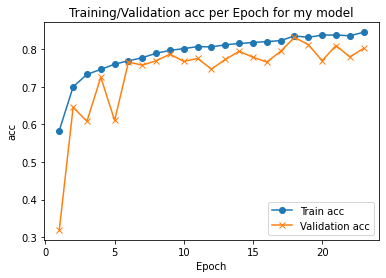

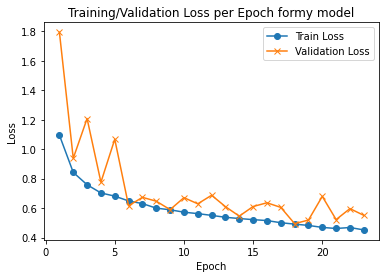

,AUC
0,0.979743
1,0.998103
2,0.960939
3,0.963286
4,0.973630
5,0.984302


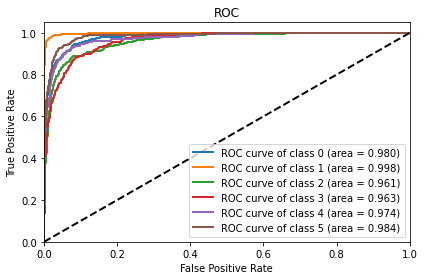

Evaluation ended
*******************************************************


In [30]:
# Training and evaluaion
# 
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)
label='my model'
print('Evalauatio and training for my model : ')
model=build_model()
model.summary()
hist = model.fit(train, epochs=50,
                     batch_size=32, validation_batch_size=32,validation_data=validation,callbacks=[earlystop])
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

**Comments**


My model had f1 score of 0.8128107716977521 after being early stopped at epoch 21. This is the best result I got after trying 8 different previous models. The graphs show some signs of exploding gradiant and overfitting. I used Dropout layer and Batch Normalization layers to reduce that. 

In [47]:
def cross_validate_model_my_model(label='my_model',epochs=15, n_split=10,batch_size=32):
    results=[]
    best_model=None
    best_f1=0
    best_hist=None
    best_actual=None
    best_predicted=None
    best_Y_pred=None
    best_rs=None
    
    train_df['label']
    print('*********************************************************')
    print('KFold Evalauatio and training with  model ', label)
    kfold=1
    for train_index,test_index in KFold(n_split).split(np.zeros(train_df['image'].size),train_df['label']): 
    #     x_train,x_test=X_train[train_index],X_train[test_index]
    #     y_train,y_test=Y_train[train_index],Y_train[test_index]
        print('** Started fold '+str(kfold))
        kfold=kfold+1
        training_data = train_df.iloc[train_index]
        testing_data = train_df.iloc[test_index]

        data_gen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.3,
                             fill_mode='nearest',validation_split=0.25,
                             horizontal_flip = True,
                             rescale=1./255)

        train_data_gen=data_gen.flow_from_dataframe(training_data, 
                       x_col = "image", y_col = "label", target_size = (150,150), # resize image
                        batch_size=batch_size,
                       class_mode = "categorical", shuffle = True,subset='training')


        validation_data_gen=data_gen.flow_from_dataframe(training_data, 
                       x_col = "image", y_col = "label", target_size = (150,150), # resize image
                        batch_size=batch_size,
                       class_mode = "categorical", shuffle = True,subset='validation')
        model=build_model()
        hist = model.fit(train_data_gen,validation_data=validation_data_gen,
                         epochs=epochs,
                         batch_size=batch_size,
                        callbacks=[EarlyStopping(patience=3)])
        x_test, y_test=x_y_from_df(testing_data)
        test_score = model.evaluate(x_test, y_test)

        actual, predicted, Y_pred=generate_actual_predicted_y(model, x_test, y_test)
        print(test_score[0], test_score[1] * 100)
        res=get_matrics(actual,predicted)
    
        if(res[2]>best_f1):
            best_f1=res[2]
            best_model=model
            best_hist=hist
            best_actual=actual
            best_predicted=predicted
            best_y_pred=Y_pred
            best_rs=res
            best_y_test=y_test
        results.append(res)
    
    #print("precision ", res[0])
    #print("recall ",res[1])
    #print("F1-Score ",res[2])
    #print("accuracy ",res[4]) 
    
    best_model.save('kfolds_'+label)
    
    plot_percision_recall_f1(results,label)
    print("Best F1-Score ",best_rs[2])
    
    print('Evaluating the best model based on f1-score after the kflods, with the testing dataset :')
    test_score = model.evaluate(X_test, Y_test)
    actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
    print(test_score[0], test_score[1] * 100)
    res=get_matrics(actual,predicted)
    print("precision ", res[0])
    print("recall ",res[1])
    print("F1-Score ",res[2])
    print("accuracy ",res[4])
    print("Confusion matrix ", res[3])
    plot_history(hist,label)
    plot_roc(Y_test,Y_pred)
    print(classification_report(actual, predicted))

    print('kflods Evaluation ended for model : '+label)
    print('*******************************************************')

*********************************************************
KFold Evalauatio and training with  model  my_model
** Started fold 1
Found 9473 validated image filenames belonging to 6 classes.
Found 3157 validated image filenames belonging to 6 classes.
Epoch 1/15
297/297 [==============================] - 75s 250ms/step - loss: 1.2366 - accuracy: 0.5078 - val_loss: 1.7002 - val_accuracy: 0.3633
Epoch 2/15
297/297 [==============================] - 73s 246ms/step - loss: 0.8936 - accuracy: 0.6744 - val_loss: 0.9058 - val_accuracy: 0.6870
Epoch 3/15
297/297 [==============================] - 73s 245ms/step - loss: 0.8276 - accuracy: 0.7107 - val_loss: 0.7939 - val_accuracy: 0.7070
Epoch 4/15
297/297 [==============================] - 73s 245ms/step - loss: 0.7627 - accuracy: 0.7274 - val_loss: 0.7880 - val_accuracy: 0.7102
Epoch 5/15
297/297 [==============================] - 73s 245ms/step - loss: 0.7381 - accuracy: 0.7382 - val_loss: 0.8938 - val_accuracy: 0.6699
Epoch 6/15
297/297 [=====

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


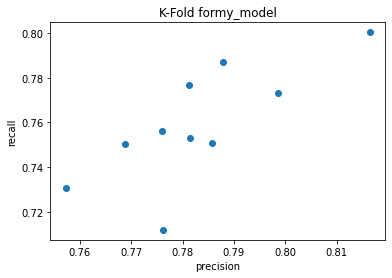

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


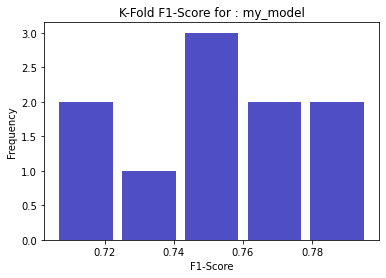

average precision for my_model :  0.7829623164253907 sd= 0.015365245898112228
average recall for my_model :  0.759012401583556 sd= 0.02497964234959537
average F1-Score for my_model :  0.7523424125146346 sd= 0.02634619114633023
average accuracy for my_model :  0.7563786290265264 sd= 0.02442999309778037
Best F1-Score  0.7963059601946054
Evaluating the best model based on f1-score after the kflods, with the testing dataset :
94/94 [==============================] - 2s 24ms/step - loss: 0.6720 - accuracy: 0.7617
0.6720392107963562 76.16666555404663
precision  0.7907773915635131
recall  0.7670843372944355
F1-Score  0.7600061400296001
accuracy  0.7616666666666667
Confusion matrix  [[394   7   7   0   2  27]
 [ 11 449   0   1   0  13]
 [ 29   8 467  16  22  11]
 [ 61   9 141 264  32  18]
 [ 56  10  56   6 365  17]
 [131  16   2   2   4 346]]


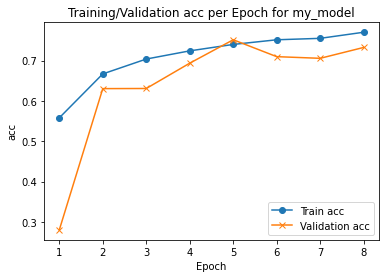

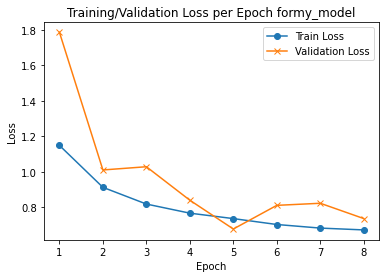

,AUC
0,0.960855
1,0.992938
2,0.949178
3,0.951161
4,0.955621
5,0.956818


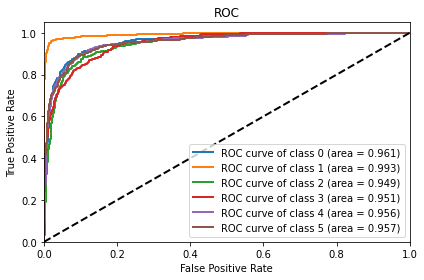

              precision    recall  f1-score   support

           0       0.58      0.90      0.70       437
           1       0.90      0.95      0.92       474
           2       0.69      0.84      0.76       553
           3       0.91      0.50      0.65       525
           4       0.86      0.72      0.78       510
           5       0.80      0.69      0.74       501

    accuracy                           0.76      3000
   macro avg       0.79      0.77      0.76      3000
weighted avg       0.79      0.76      0.76      3000

kflods Evaluation ended for model : my_model
*******************************************************


In [49]:
## Cross validatio
cross_validate_model_my_model(n_split=10)

**Summary**

The cross validation results show that my model had an average f1 of 0.7800005778988669.However, the best model got a decent f1 score of 0.8201876346587356. Moreover, Class 2,3 and 4 got the lowest f1 scores while class 1 got the best f1 score. Seems like my model is confusing class 2 with 3  , class 3 with 2 .and class 4 with both 2 and 3 which reduced the f1 score. The same applies for the percision, recall and roc curves. The accuracy average and best is close the f1 score numbers and following the same pattern. The history graphs show the validation accuracy is still following the training accuracy but it is not very smooth. This might be an indication of exploding gradient.  

# **Part 2 : Transfer Learning**

**With corss validation**

In [6]:
BATCH_SIZE=32
EPOCHS=6
N_SPLIT=5
n_samples=train_df['image'].size
Y=train_df['label']
print(n_samples)

14034


In [7]:
## This method is meant to cross validat the pre trained models using the label to get the model
def cross_validate(label='',epochs=5, n_split=5,batch_size=32):
    results=[]
    best_model=None
    best_f1=0
    best_hist=None
    best_actual=None
    best_predicted=None
    best_Y_pred=None
    best_rs=None
    print('*********************************************************')
    print('KFold Evalauatio and training with the pre trained model : ', label)
    kfold=1
    for train_index,test_index in KFold(n_split).split(np.zeros(train_df['image'].size),Y): 
    #     x_train,x_test=X_train[train_index],X_train[test_index]
    #     y_train,y_test=Y_train[train_index],Y_train[test_index]
        print('** Started fold '+str(kfold)+' **')
        kfold=kfold+1
        training_data = train_df.iloc[train_index]
        testing_data = train_df.iloc[test_index]

        data_gen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.3,
                             fill_mode='nearest',validation_split=0.25,
                             horizontal_flip = True,
                             rescale=1./255)

        train_data_gen=data_gen.flow_from_dataframe(training_data, 
                       x_col = "image", y_col = "label", target_size = (150,150), # resize image
                        batch_size=batch_size,
                       class_mode = "categorical", shuffle = True,subset='training')


        validation_data_gen=data_gen.flow_from_dataframe(training_data, 
                       x_col = "image", y_col = "label", target_size = (150,150), # resize image
                        batch_size=batch_size,
                       class_mode = "categorical", shuffle = True,subset='validation')

        model=create_model(label)
        hist = model.fit(train_data_gen,validation_data=validation_data_gen,
                         epochs=epochs,
                         batch_size=batch_size,)
        x_test, y_test=x_y_from_df(testing_data)
        test_score = model.evaluate(x_test, y_test)

        actual, predicted, Y_pred=generate_actual_predicted_y(model, x_test, y_test)
        print(test_score[0], test_score[1] * 100)
        res=get_matrics(actual,predicted)
    
        if(res[2]>best_f1):
            best_f1=res[2]
            best_model=model
            best_hist=hist
            best_actual=actual
            best_predicted=predicted
            best_y_pred=Y_pred
            best_rs=res
            best_y_test=y_test
        results.append(res)
    
    #print("precision ", res[0])
    #print("recall ",res[1])
    #print("F1-Score ",res[2])
    #print("accuracy ",res[4]) 
    best_model.save('kfolds_'+label)

    plot_percision_recall_f1(results,label)
    print('Metrics for the best model after kflods for '+ label)
    print("Confusion matrix \n", best_rs[3])
    print("Best F1-Score ",best_rs[2])
    plot_history(best_hist,label)
    plot_roc(best_y_test,best_y_pred)
    print(classification_report(best_actual, best_predicted))
    print('KFold Evaluation ended')
    print('*******************************************************')

*********************************************************
KFold Evalauatio and training with the pre trained model :  InceptionV3
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
Epoch 1/6
264/264 [==============================] - 69s 246ms/step - loss: 0.7145 - accuracy: 0.7419 - val_loss: 0.3825 - val_accuracy: 0.8607
Epoch 2/6
264/264 [==============================] - 61s 233ms/step - loss: 0.4184 - accuracy: 0.8434 - val_loss: 0.3717 - val_accuracy: 0.8699
Epoch 3/6
264/264 [==============================] - 61s 232ms/step - loss: 0.3939 - accuracy: 0.8543 - val_loss: 0.3918 - val_accuracy: 0.8532
Epoch 4/6
264/264 [==============================] - 61s 232ms/step - loss: 0.3782 - accuracy: 0.8555 - val_loss: 0.3452 - val_accuracy: 0.8778
Epoch 5/6
264/264 [==============================] - 61s 232ms/step - loss: 0.3518 - accuracy: 0.8718 - val_loss: 0.3579 - val_accuracy: 0.8703
Epoch 6

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


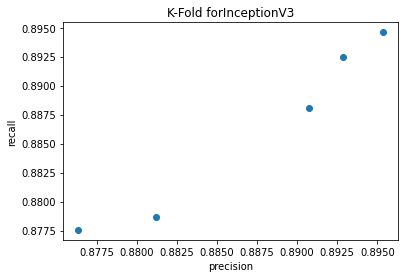

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


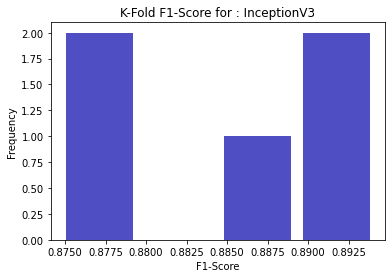

average precision for InceptionV3 :  0.8872949560094195 sd= 0.007271642217872412
average recall for InceptionV3 :  0.8862672234036845 sd= 0.006993260321772256
average F1-Score for InceptionV3 :  0.8854750712662938 sd= 0.007940398293426956
average accuracy for InceptionV3 :  0.883854054914643 sd= 0.00796483495011629
Metrics for the best model after kflods for InceptionV3
Confusion matrix 
 [[417   0   2   1   5  29]
 [  1 420   1   2   3   0]
 [  0   3 393  88  13   1]
 [  0   0  47 423  16   0]
 [  3   2   9  20 407   3]
 [ 49   2   0   1   3 442]]
Best F1-Score  0.8942028434762729


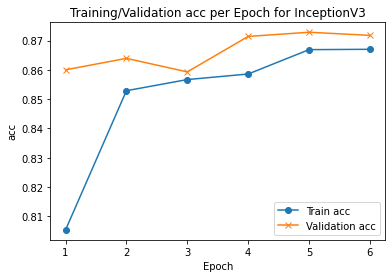

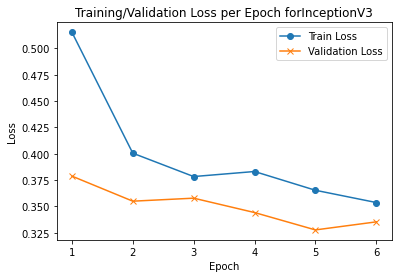

,AUC
0,0.992286
1,0.998915
2,0.979937
3,0.976627
4,0.992488
5,0.993233


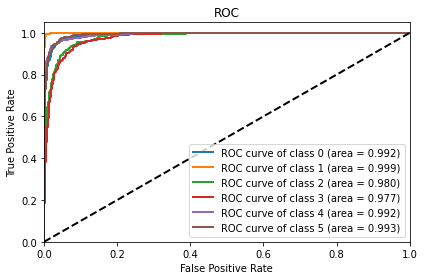

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       454
           1       0.98      0.98      0.98       427
           2       0.87      0.79      0.83       498
           3       0.79      0.87      0.83       486
           4       0.91      0.92      0.91       444
           5       0.93      0.89      0.91       497

    accuracy                           0.89      2806
   macro avg       0.90      0.89      0.89      2806
weighted avg       0.89      0.89      0.89      2806

KFold Evaluation ended
*******************************************************


In [38]:
label=MODELS[0]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


We can see that Inception V3 had an f1 average of 0.8854750712662938  and best f1 of 0.8942028434762729 .
We can also see that validation accuracy is higher than the testing accuracy. This might be anindicator that more epochs
might improve performance. We can see the f1-score was worst for class 2 and class 3. This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.


*********************************************************
KFold Evalauatio and training with the pre trained model :  MobileNetV2
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/6
264/264 [==============================] - 62s 225ms/step - loss: 0.7156 - accuracy: 0.7485 - val_loss: 0.3774 - val_accuracy: 0.8724
Epoch 2/6
264/264 [==============================] - 59s 225ms/step - loss: 0.3678 - accuracy: 0.8639 - val_loss: 0.3435 - val_accuracy: 0.8763
Epoch 3/6
264/264 [==============================] - 59s 223ms/step - loss: 0.3370 - accuracy: 0.8780 - val_loss: 0.3517 - val_accuracy: 0.8724
Epoch 4/6
264/264 [==============================] - 59s 223ms/step - loss: 0.2971 - accuracy: 0.8884 - val_loss: 0.3802 - val_accuracy: 0.8642
Epoch 5/6
264/264 [==============================] - 59s 224ms/step - loss: 0.3168 - acc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


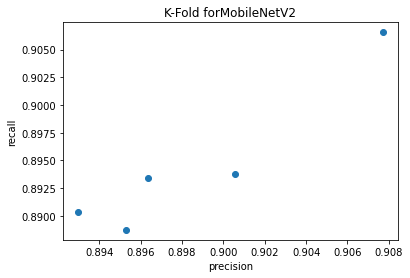

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


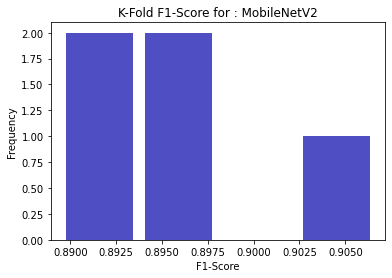

average precision for MobileNetV2 :  0.8985830606386818 sd= 0.0051764571588047165
average recall for MobileNetV2 :  0.8945574374715566 sd= 0.00629897435623199
average F1-Score for MobileNetV2 :  0.8954336138802169 sd= 0.0060378718489644935
average accuracy for MobileNetV2 :  0.893117501531783 sd= 0.0061829288654017146
Metrics for the best model after kflods for MobileNetV2
Confusion matrix 
 [[425   1   0   6   3  19]
 [  0 424   0   3   0   0]
 [  0   5 420  63   6   4]
 [  1   1  56 419   9   0]
 [  2   1  13  25 402   1]
 [ 46   4   0   0   0 447]]
Best F1-Score  0.9066779162081732


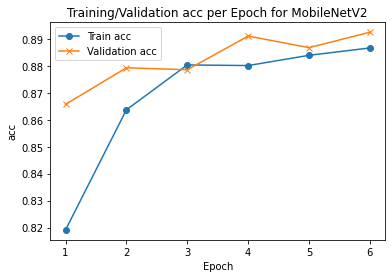

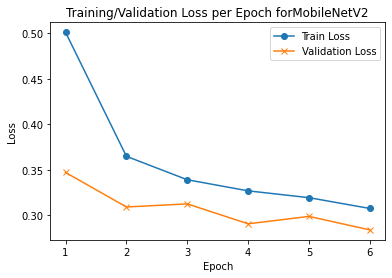

,AUC
0,0.994982
1,0.998868
2,0.978373
3,0.977365
4,0.996101
5,0.996193


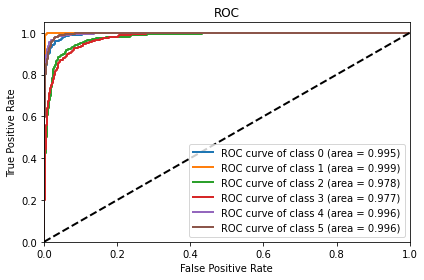

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       454
           1       0.97      0.99      0.98       427
           2       0.86      0.84      0.85       498
           3       0.81      0.86      0.84       486
           4       0.96      0.91      0.93       444
           5       0.95      0.90      0.92       497

    accuracy                           0.90      2806
   macro avg       0.91      0.91      0.91      2806
weighted avg       0.91      0.90      0.90      2806

KFold Evaluation ended
*******************************************************


In [39]:
########################################################################################
label=MODELS[1]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


*********************************************************
KFold Evalauatio and training with the pre trained model :  NASNetMobile
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
Unknown model, will train MobileNet instead.
5578752/5577668 [==============================] - 0s 0us/step
Epoch 1/6
264/264 [==============================] - 62s 225ms/step - loss: 0.7222 - accuracy: 0.7322 - val_loss: 0.3618 - val_accuracy: 0.8724
Epoch 2/6
264/264 [==============================] - 58s 219ms/step - loss: 0.3622 - accuracy: 0.8666 - val_loss: 0.3459 - val_accuracy: 0.8785
Epoch 3/6
264/264 [==============================] - 58s 221ms/step - loss: 0.3318 - accuracy: 0.8769 - val_loss: 0.3430 - val_accuracy: 0.8824
Epoch 4/6
264/264 [==============================] - 58s 221ms/step - loss: 0.3203 - accuracy: 0.8860 - val_loss: 0.3350 - val_accuracy: 0.8785
Epoch 5/6
264/264 [=======================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


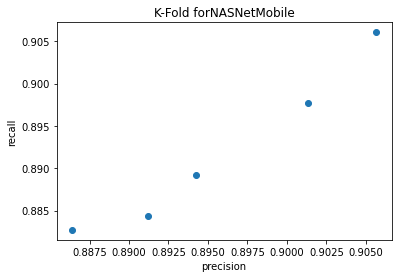

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


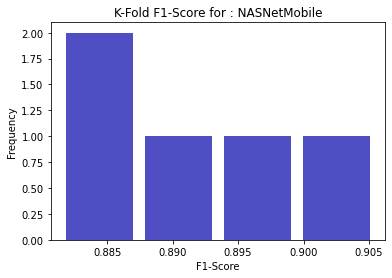

average precision for NASNetMobile :  0.8957655775559396 sd= 0.0069313561551119585
average recall for NASNetMobile :  0.8920108674887185 sd= 0.00874117643515025
average F1-Score for NASNetMobile :  0.891887001357885 sd= 0.008908983380233014
average accuracy for NASNetMobile :  0.8904099338254505 sd= 0.00918016836161782
Metrics for the best model after kflods for NASNetMobile
Confusion matrix 
 [[409   1   0   1   3  40]
 [  0 423   1   2   0   1]
 [  0   2 404  73  16   3]
 [  0   2  53 414  16   1]
 [  2   0   6  12 421   3]
 [ 27   4   1   0   1 464]]
Best F1-Score  0.9055412525107269


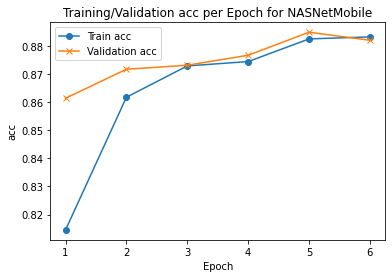

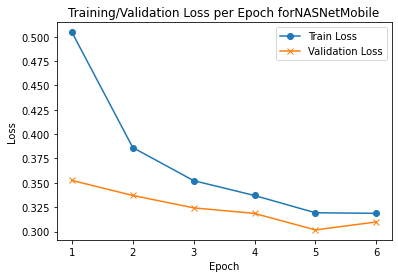

,AUC
0,0.994776
1,0.998699
2,0.979745
3,0.981448
4,0.995203
5,0.994867


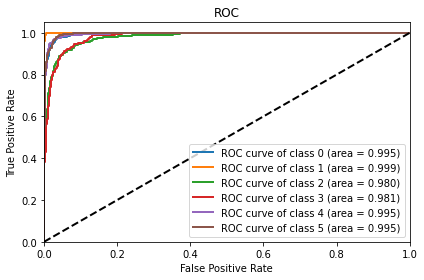

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       454
           1       0.98      0.99      0.98       427
           2       0.87      0.81      0.84       498
           3       0.82      0.85      0.84       486
           4       0.92      0.95      0.93       444
           5       0.91      0.93      0.92       497

    accuracy                           0.90      2806
   macro avg       0.91      0.91      0.91      2806
weighted avg       0.90      0.90      0.90      2806

KFold Evaluation ended
*******************************************************


In [40]:
########################################################################################
label=MODELS[2]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


We can see that NASNetMobile  performed slightly worsy than MobileNet  with an f1 average of 0.891887001357885   and best f1 of 0.9055412525107269
we can see the f1-score and roc curves were worst for class 2 and class 3 as the previous models . 
This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.
Also, this model might need more epochs to increase performance and validation metrics are higher than the training ones


*********************************************************
KFold Evalauatio and training with the pre trained model :  Xception
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/6
264/264 [==============================] - 66s 237ms/step - loss: 0.5579 - accuracy: 0.7954 - val_loss: 0.3512 - val_accuracy: 0.8717
Epoch 2/6
264/264 [==============================] - 62s 233ms/step - loss: 0.3363 - accuracy: 0.8773 - val_loss: 0.3424 - val_accuracy: 0.8763
Epoch 3/6
264/264 [==============================] - 61s 233ms/step - loss: 0.3242 - accuracy: 0.8828 - val_loss: 0.3502 - val_accuracy: 0.8753
Epoch 4/6
264/264 [==============================] - 62s 235ms/step - loss: 0.2972 - accuracy: 0.8866 - val_loss: 0.3112 - val_accuracy: 0.8849
Epoch 5/6
264/264 [==============================] - 62s 235ms/step - loss: 0.2790 - accu

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


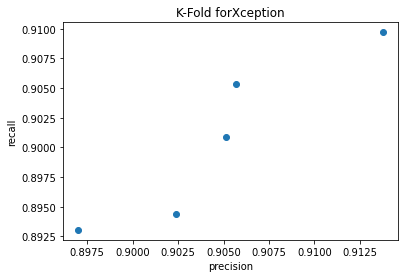

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


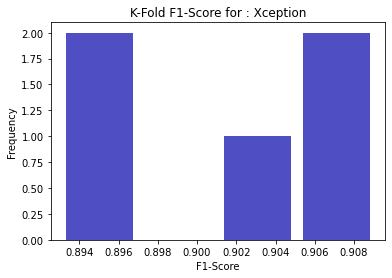

average precision for Xception :  0.9047890979121084 sd= 0.005438928053719112
average recall for Xception :  0.9006780784425261 sd= 0.006352098873651269
average F1-Score for Xception :  0.900477708117332 sd= 0.006464268845072696
average accuracy for Xception :  0.8987453472011854 sd= 0.006210579269630616
Metrics for the best model after kflods for Xception
Confusion matrix 
 [[385   2   1   0   4  41]
 [  0 438   2   4   2   3]
 [  0   1 416  29  12   2]
 [  0   0 115 397   7   1]
 [  0   1  15   5 448   0]
 [ 10   0   0   3   1 462]]
Best F1-Score  0.9091226030905059


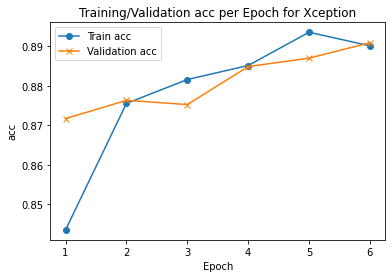

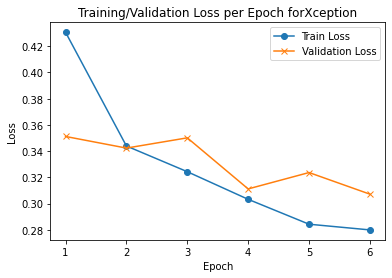

,AUC
0,0.996104
1,0.999802
2,0.977044
3,0.983187
4,0.997363
5,0.996318


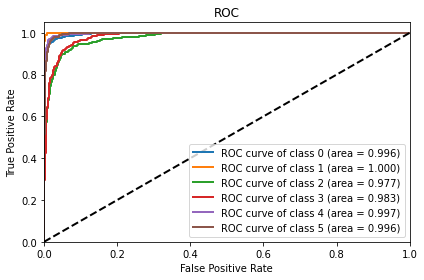

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       433
           1       0.99      0.98      0.98       449
           2       0.76      0.90      0.82       460
           3       0.91      0.76      0.83       520
           4       0.95      0.96      0.95       469
           5       0.91      0.97      0.94       476

    accuracy                           0.91      2807
   macro avg       0.91      0.91      0.91      2807
weighted avg       0.91      0.91      0.91      2807

KFold Evaluation ended
*******************************************************


In [42]:
########################################################################################
label=MODELS[4]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


We can see that Xception performed slightly better than NASNetMobile  with an f1 average of 0.900477708117332    and best f1 of 0.9091226030905059
we can see the f1-score and roc curves were worst for class 2 and class 3 as the previous models . 
This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.
Also, this model might be showing exploding gradient based on the history graphs.


*********************************************************
KFold Evalauatio and training with the pre trained model :  DenseNet169
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
51879936/51877672 [==============================] - 1s 0us/step
Epoch 1/6
264/264 [==============================] - 74s 247ms/step - loss: 0.5683 - accuracy: 0.7878 - val_loss: 0.3373 - val_accuracy: 0.8803
Epoch 2/6
264/264 [==============================] - 62s 235ms/step - loss: 0.3169 - accuracy: 0.8797 - val_loss: 0.3107 - val_accuracy: 0.8899
Epoch 3/6
264/264 [==============================] - 62s 234ms/step - loss: 0.2939 - accuracy: 0.8928 - val_loss: 0.3112 - val_accuracy: 0.8934
Epoch 4/6
264/264 [==============================] - 62s 235ms/step - loss: 0.2717 - accuracy: 0.8948 - val_loss: 0.2993 - val_accuracy: 0.8988
Epoch 5/6
264/264 [==============================] - 62s 237ms/step - loss: 0.2667 - a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


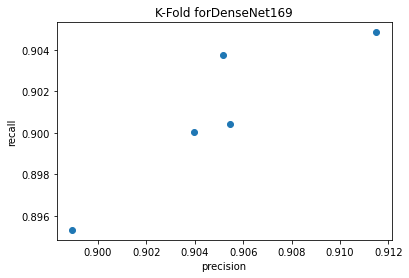

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


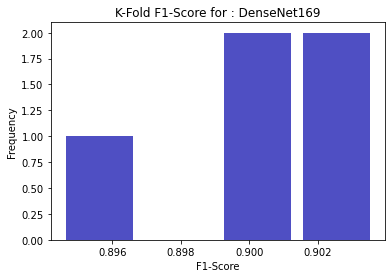

average precision for DenseNet169 :  0.9050026349917747 sd= 0.004014520149574862
average recall for DenseNet169 :  0.9008769719924684 sd= 0.003346965208336481
average F1-Score for DenseNet169 :  0.900638267237721 sd= 0.0032949102521741473
average accuracy for DenseNet169 :  0.8988885590727387 sd= 0.002586982892214355
Metrics for the best model after kflods for DenseNet169
Confusion matrix 
 [[394   0   1   0   2  53]
 [  0 424   0   3   6   5]
 [  3   3 410  50  20   1]
 [  1   1  65 404  19   0]
 [  4   0   9   4 428   4]
 [ 15   1   1   1   2 473]]
Best F1-Score  0.9037009378020464


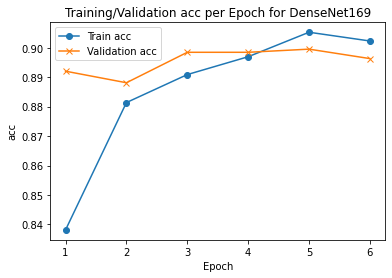

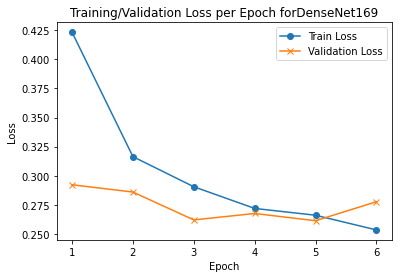

,AUC
0,0.994269
1,0.997853
2,0.975786
3,0.984283
4,0.995479
5,0.994850


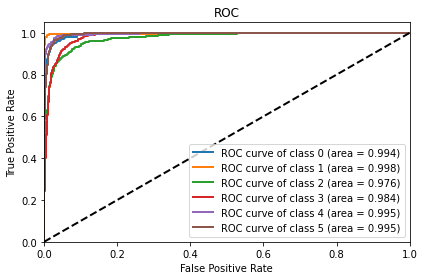

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       450
           1       0.99      0.97      0.98       438
           2       0.84      0.84      0.84       487
           3       0.87      0.82      0.85       490
           4       0.90      0.95      0.92       449
           5       0.88      0.96      0.92       493

    accuracy                           0.90      2807
   macro avg       0.91      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807

KFold Evaluation ended
*******************************************************


In [43]:
########################################################################################
label=MODELS[5]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


We can see that DenseNet169 is the best transfer learning model with an f1 average of 0.900638267237721     and best f1 of 0.9037009378020464
we can see the f1-score and roc curves were worst for class 2 and class 3 as the previous models . 
This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.


*********************************************************
KFold Evalauatio and training with the pre trained model :  VGG19
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/3
264/264 [==============================] - 679s 3s/step - loss: 1.0693 - accuracy: 0.5986 - val_loss: 0.6997 - val_accuracy: 0.7445
Epoch 2/3
264/264 [==============================] - 661s 3s/step - loss: 0.5984 - accuracy: 0.7677 - val_loss: 0.5181 - val_accuracy: 0.8165
Epoch 3/3
88/88 [==============================] - 171s 2s/step - loss: 0.4462 - accuracy: 0.8322
0.44615626335144043 83.22051763534546
** Started fold 2 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
Epoch 1/3
264/264 [==============================] - 662s 3s/step - loss: 1.0550 - accuracy: 0.5906 - val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


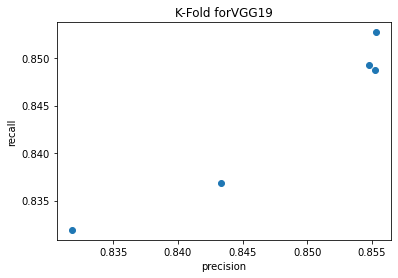

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


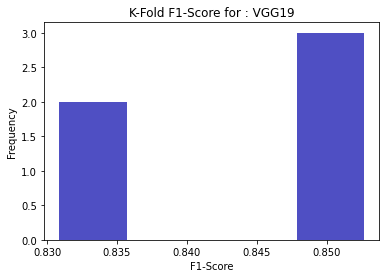

average precision for VGG19 :  0.8480910316104442 sd= 0.009345440963858127
average recall for VGG19 :  0.8438847504220233 sd= 0.008041205470995001
average F1-Score for VGG19 :  0.8428994558935354 sd= 0.008735502702694933
average accuracy for VGG19 :  0.8412431907706551 sd= 0.008829403928718792
Metrics for the best model after kflods for VGG19
Confusion matrix 
 [[371   5   0   3   4  61]
 [  0 441   5   6   5   3]
 [  4   3 402  50  20   6]
 [  1   1  86 363  34   4]
 [ 17   0  31  30 360   4]
 [ 21   5   2   1   2 456]]
Best F1-Score  0.8530634833615895


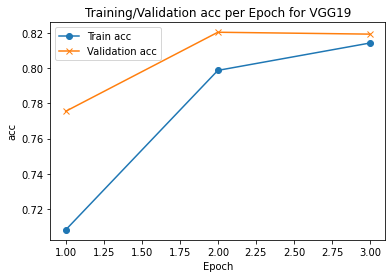

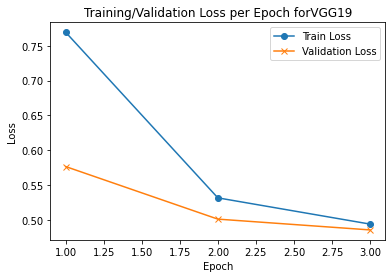

,AUC
0,0.985411
1,0.997365
2,0.964342
3,0.967909
4,0.980822
5,0.988750


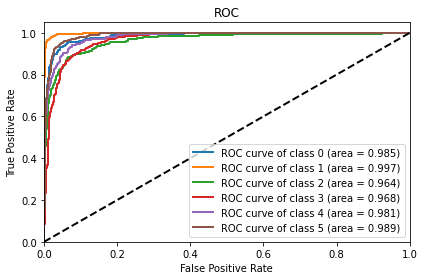

              precision    recall  f1-score   support

           0       0.90      0.84      0.86       444
           1       0.97      0.96      0.96       460
           2       0.76      0.83      0.80       485
           3       0.80      0.74      0.77       489
           4       0.85      0.81      0.83       442
           5       0.85      0.94      0.89       487

    accuracy                           0.85      2807
   macro avg       0.86      0.85      0.85      2807
weighted avg       0.85      0.85      0.85      2807

KFold Evaluation ended
*******************************************************


In [8]:
################################################################################################################################################################################
label=MODELS[6]
cross_validate(label, batch_size=BATCH_SIZE, epochs=3,n_split=N_SPLIT )#Only 3 epochs because this model was taking 11 mins per epoch while the rest 
#of models had average of 1 minute per epoch

We can see that VGG19 is the worst transfer learning model with an f1 average of 0.8428994558935354   and best f1 of 0.8530634833615895
we can see the f1-score and roc curves performed poorly for class 2 and class 3 as the previous models but with even less values  . 
This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.
 Also notice that training for this model was taking 10 times more than the other models in my environment so I had to do 3 epochs only.

*********************************************************
KFold Evalauatio and training with the pre trained model :  MobileNet
** Started fold 1 **
Found 8421 validated image filenames belonging to 6 classes.
Found 2806 validated image filenames belonging to 6 classes.
Unknown model, will train MobileNet instead.
Epoch 1/6
264/264 [==============================] - 62s 229ms/step - loss: 0.6680 - accuracy: 0.7566 - val_loss: 0.3835 - val_accuracy: 0.8592
Epoch 2/6
264/264 [==============================] - 60s 229ms/step - loss: 0.3756 - accuracy: 0.8641 - val_loss: 0.3771 - val_accuracy: 0.8653
Epoch 3/6
264/264 [==============================] - 60s 226ms/step - loss: 0.3363 - accuracy: 0.8762 - val_loss: 0.3584 - val_accuracy: 0.8706
Epoch 4/6
264/264 [==============================] - 58s 219ms/step - loss: 0.3087 - accuracy: 0.8836 - val_loss: 0.3452 - val_accuracy: 0.8738
Epoch 5/6
264/264 [==============================] - 58s 218ms/step - loss: 0.3111 - accuracy: 0.8838 - val_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


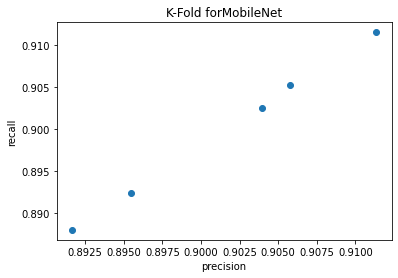

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


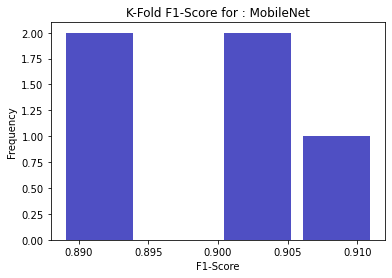

average precision for MobileNet :  0.9016353628099534 sd= 0.007134972694733398
average recall for MobileNet :  0.8999574905718696 sd= 0.008595296045224006
average F1-Score for MobileNet :  0.9000277260435754 sd= 0.008255243944561242
average accuracy for MobileNet :  0.8983191395302599 sd= 0.008025851599595457
Metrics for the best model after kflods for MobileNet
Confusion matrix 
 [[422   1   1   1   1  28]
 [  0 423   1   2   0   1]
 [  0   3 415  67  10   3]
 [  0   1  53 417  15   0]
 [  3   0  10  14 413   4]
 [ 33   3   0   0   0 461]]
Best F1-Score  0.9113534787592522


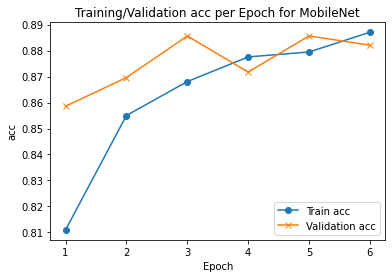

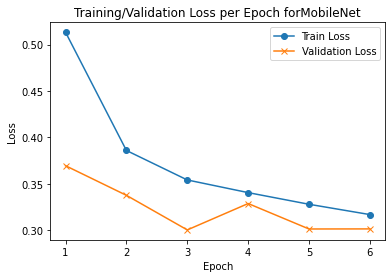

,AUC
0,0.994662
1,0.998797
2,0.980697
3,0.981081
4,0.995947
5,0.995135


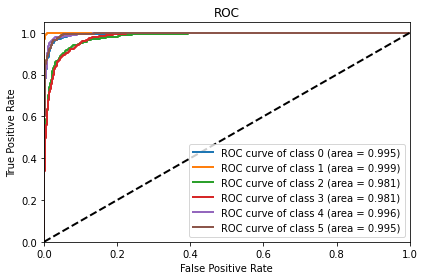

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       454
           1       0.98      0.99      0.99       427
           2       0.86      0.83      0.85       498
           3       0.83      0.86      0.84       486
           4       0.94      0.93      0.94       444
           5       0.93      0.93      0.93       497

    accuracy                           0.91      2806
   macro avg       0.91      0.91      0.91      2806
weighted avg       0.91      0.91      0.91      2806

KFold Evaluation ended
*******************************************************


In [45]:
########################################################################################
label=MODELS[8]
cross_validate(label, batch_size=BATCH_SIZE, epochs=EPOCHS,n_split=N_SPLIT )


We can see that MobileNet is among the best transfer learning model with an f1 average of 0.9000277260435754    and best f1 of 0.9113534787592522
we can see the f1-score and roc curves performed less for class 2 and class 3 as the previous models but with even less values  . 
This can be explained by the fact that class 2: glacier and 3: mountain
are confusing the model as shown by the confusion matrix.
Validation metrics are also higher than the training metrics, perhaps more epochs will imporve performance


**Without cross validation** 





*********************************************************
Evalauatio and training with the pre trained model :  InceptionV3
Epoch 1/20
329/329 [==============================] - 101s 287ms/step - loss: 0.6452 - accuracy: 0.7670 - val_loss: 0.3227 - val_accuracy: 0.8788

Epoch 00001: val_accuracy improved from -inf to 0.87878, saving model to best_model_InceptionV3
Epoch 2/20
329/329 [==============================] - 81s 245ms/step - loss: 0.3642 - accuracy: 0.8666 - val_loss: 0.3180 - val_accuracy: 0.8782

Epoch 00002: val_accuracy did not improve from 0.87878
Epoch 3/20
329/329 [==============================] - 77s 235ms/step - loss: 0.3292 - accuracy: 0.8759 - val_loss: 0.3159 - val_accuracy: 0.8928

Epoch 00003: val_accuracy improved from 0.87878 to 0.89276, saving model to best_model_InceptionV3
Epoch 4/20
329/329 [==============================] - 77s 235ms/step - loss: 0.3345 - accuracy: 0.8755 - val_loss: 0.3384 - val_accuracy: 0.8708

Epoch 00004: val_accuracy did not improve

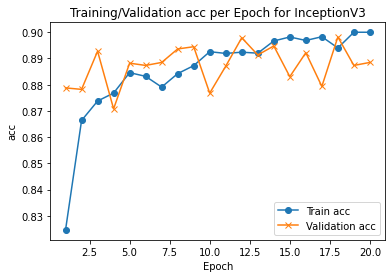

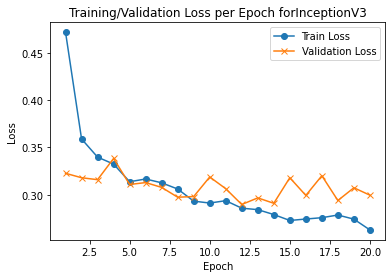

,AUC
0,0.993343
1,0.999667
2,0.976477
3,0.978355
4,0.996583
5,0.994368


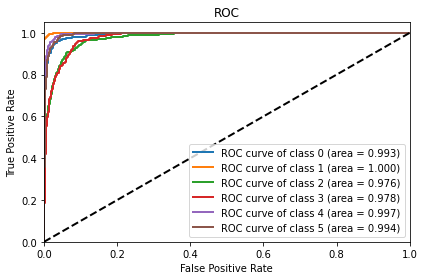

Evaluation ended
*******************************************************


In [67]:
label=MODELS[0]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')


*********************************************************
Evalauatio and training with the pre trained model :  MobileNetV2
Epoch 1/20
329/329 [==============================] - 91s 269ms/step - loss: 0.5365 - accuracy: 0.8048 - val_loss: 0.3094 - val_accuracy: 0.8899

Epoch 00001: val_accuracy improved from -inf to 0.88990, saving model to best_model_MobileNetV2
Epoch 2/20
329/329 [==============================] - 76s 231ms/step - loss: 0.3215 - accuracy: 0.8789 - val_loss: 0.3072 - val_accuracy: 0.8873

Epoch 00002: val_accuracy did not improve from 0.88990
Epoch 3/20
329/329 [==============================] - 75s 228ms/step - loss: 0.2719 - accuracy: 0.9041 - val_loss: 0.2864 - val_accuracy: 0.8848

Epoch 00003: val_accuracy did not improve from 0.88990
Epoch 4/20
329/329 [==============================] - 84s 254ms/step - loss: 0.2674 - accuracy: 0.9028 - val_loss: 0.2968 - val_accuracy: 0.8933

Epoch 00004: val_accuracy improved from 0.88990 to 0.89333, saving model to best_model

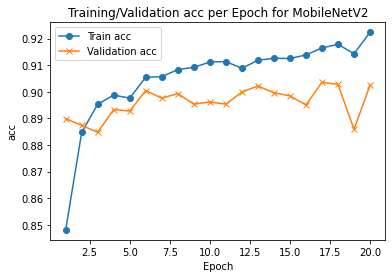

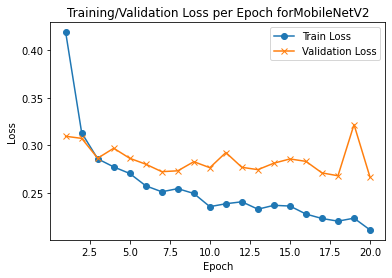

,AUC
0,0.993454
1,0.999758
2,0.974878
3,0.978908
4,0.995845
5,0.994628


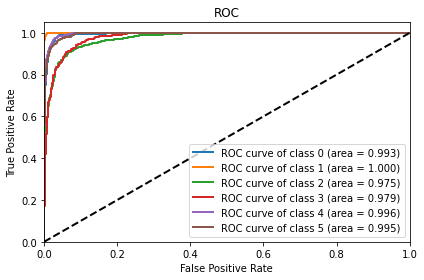

Evaluation ended
*******************************************************


In [68]:
label=MODELS[1]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

*********************************************************
Evalauatio and training with the pre trained model :  NASNetMobile
Unknown model, will train MobileNet instead.
Epoch 1/20
329/329 [==============================] - 77s 230ms/step - loss: 0.6176 - accuracy: 0.7763 - val_loss: 0.3305 - val_accuracy: 0.8748

Epoch 00001: val_accuracy improved from -inf to 0.87479, saving model to best_model_NASNetMobile
Epoch 2/20
329/329 [==============================] - 74s 225ms/step - loss: 0.3324 - accuracy: 0.8747 - val_loss: 0.3076 - val_accuracy: 0.8819

Epoch 00002: val_accuracy improved from 0.87479 to 0.88192, saving model to best_model_NASNetMobile
Epoch 3/20
329/329 [==============================] - 76s 230ms/step - loss: 0.2910 - accuracy: 0.8941 - val_loss: 0.3104 - val_accuracy: 0.8836

Epoch 00003: val_accuracy improved from 0.88192 to 0.88363, saving model to best_model_NASNetMobile
Epoch 4/20
329/329 [==============================] - 114s 348ms/step - loss: 0.2771 - accuracy

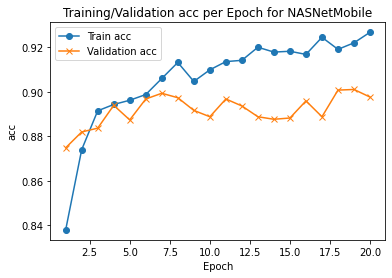

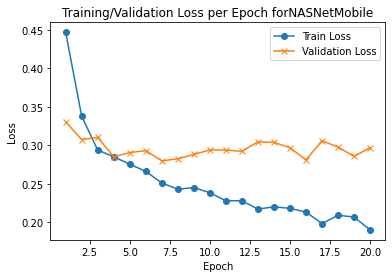

,AUC
0,0.994649
1,0.999803
2,0.976162
3,0.981914
4,0.993540
5,0.996327


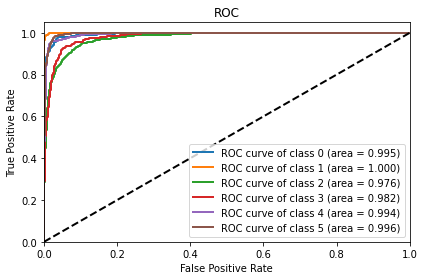

Evaluation ended
*******************************************************


In [69]:
label=MODELS[2]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

*********************************************************
Evalauatio and training with the pre trained model :  Xception
Epoch 1/20
329/329 [==============================] - 81s 239ms/step - loss: 0.4891 - accuracy: 0.8162 - val_loss: 0.3417 - val_accuracy: 0.8768

Epoch 00001: val_accuracy improved from -inf to 0.87678, saving model to best_model_Xception
Epoch 2/20
329/329 [==============================] - 78s 238ms/step - loss: 0.3097 - accuracy: 0.8844 - val_loss: 0.3056 - val_accuracy: 0.8851

Epoch 00002: val_accuracy improved from 0.87678 to 0.88505, saving model to best_model_Xception
Epoch 3/20
329/329 [==============================] - 95s 290ms/step - loss: 0.2748 - accuracy: 0.8945 - val_loss: 0.2816 - val_accuracy: 0.8916

Epoch 00003: val_accuracy improved from 0.88505 to 0.89161, saving model to best_model_Xception
Epoch 4/20
329/329 [==============================] - 77s 235ms/step - loss: 0.2609 - accuracy: 0.9019 - val_loss: 0.3066 - val_accuracy: 0.8876

Epoch 0000

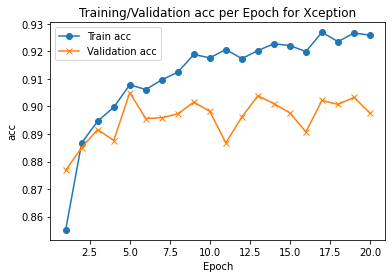

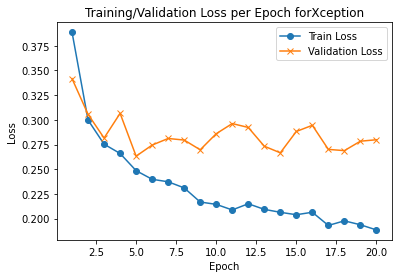

,AUC
0,0.993693
1,0.999812
2,0.980700
3,0.985570
4,0.997915
5,0.994052


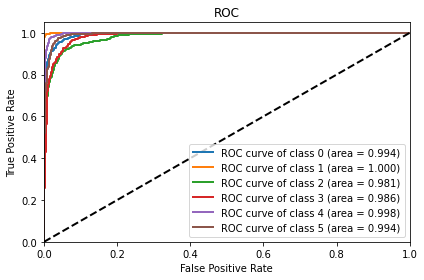

Evaluation ended
*******************************************************


In [71]:
label=MODELS[4]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

*********************************************************
Evalauatio and training with the pre trained model :  DenseNet169
Epoch 1/20
329/329 [==============================] - 89s 247ms/step - loss: 0.4969 - accuracy: 0.8198 - val_loss: 0.2955 - val_accuracy: 0.8873

Epoch 00001: val_accuracy improved from -inf to 0.88734, saving model to best_model_DenseNet169
Epoch 2/20
329/329 [==============================] - 78s 236ms/step - loss: 0.2738 - accuracy: 0.9003 - val_loss: 0.2679 - val_accuracy: 0.8967

Epoch 00002: val_accuracy improved from 0.88734 to 0.89675, saving model to best_model_DenseNet169
Epoch 3/20
329/329 [==============================] - 80s 242ms/step - loss: 0.2525 - accuracy: 0.9051 - val_loss: 0.2475 - val_accuracy: 0.9116

Epoch 00003: val_accuracy improved from 0.89675 to 0.91158, saving model to best_model_DenseNet169
Epoch 4/20
329/329 [==============================] - 78s 236ms/step - loss: 0.2284 - accuracy: 0.9153 - val_loss: 0.2514 - val_accuracy: 0.9099

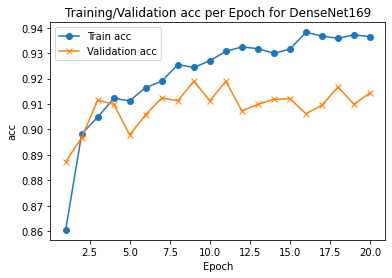

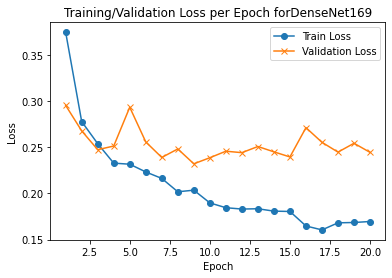

,AUC
0,0.995770
1,0.999942
2,0.978370
3,0.984913
4,0.997034
5,0.996292


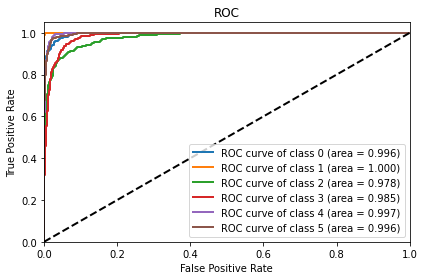

Evaluation ended
*******************************************************


In [72]:
label=MODELS[5]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

*********************************************************
Evalauatio and training with the pre trained model :  VGG19
80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/5
329/329 [==============================] - 78s 235ms/step - loss: 0.9540 - accuracy: 0.6397 - val_loss: 0.5129 - val_accuracy: 0.8018

Epoch 00001: val_accuracy improved from -inf to 0.80177, saving model to best_model_VGG19
Epoch 2/5
329/329 [==============================] - 77s 233ms/step - loss: 0.5009 - accuracy: 0.8094 - val_loss: 0.4551 - val_accuracy: 0.8297

Epoch 00002: val_accuracy improved from 0.80177 to 0.82972, saving model to best_model_VGG19
Epoch 3/5
329/329 [==============================] - 77s 233ms/step - loss: 0.4378 - accuracy: 0.8349 - val_loss: 0.4540 - val_accuracy: 0.8263

Epoch 00003: val_accuracy did not improve from 0.82972
Epoch 4/5
329/329 [==============================] - 84s 255ms/step - loss: 0.4360 - accuracy: 0.8362 - val_loss: 0.4580 - val_accuracy: 0.8274


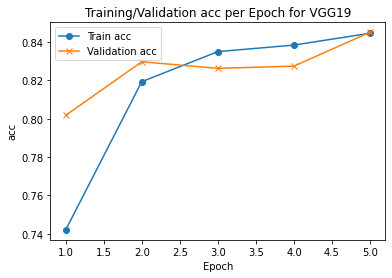

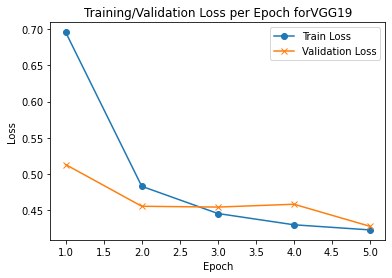

,AUC
0,0.988442
1,0.999530
2,0.962393
3,0.960743
4,0.981674
5,0.990728


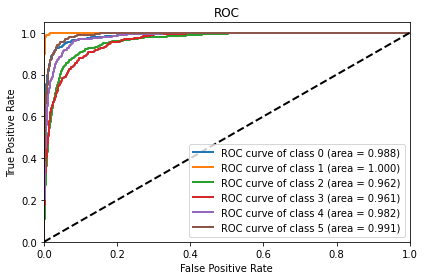

Evaluation ended
*******************************************************


In [11]:
label=MODELS[6]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=5,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

*********************************************************
Evalauatio and training with the pre trained model :  MobileNet
Unknown model, will train MobileNet instead.
Epoch 1/20
329/329 [==============================] - 79s 236ms/step - loss: 0.6163 - accuracy: 0.7639 - val_loss: 0.3478 - val_accuracy: 0.8708

Epoch 00001: val_accuracy improved from -inf to 0.87079, saving model to best_model_MobileNet
Epoch 2/20
329/329 [==============================] - 74s 226ms/step - loss: 0.3204 - accuracy: 0.8820 - val_loss: 0.3137 - val_accuracy: 0.8822

Epoch 00002: val_accuracy improved from 0.87079 to 0.88220, saving model to best_model_MobileNet
Epoch 3/20
329/329 [==============================] - 74s 224ms/step - loss: 0.3064 - accuracy: 0.8875 - val_loss: 0.2952 - val_accuracy: 0.8928

Epoch 00003: val_accuracy improved from 0.88220 to 0.89276, saving model to best_model_MobileNet
Epoch 4/20
329/329 [==============================] - 74s 224ms/step - loss: 0.2925 - accuracy: 0.8932 - va

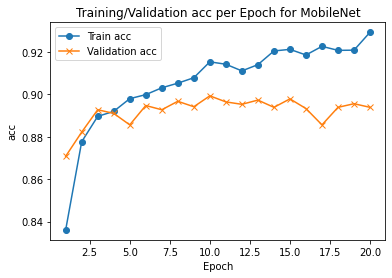

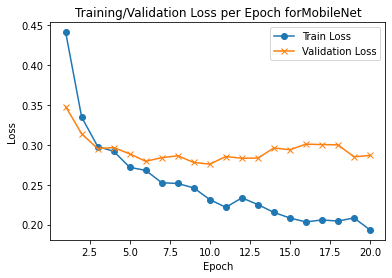

,AUC
0,0.994969
1,0.999701
2,0.975423
3,0.981219
4,0.993975
5,0.995985


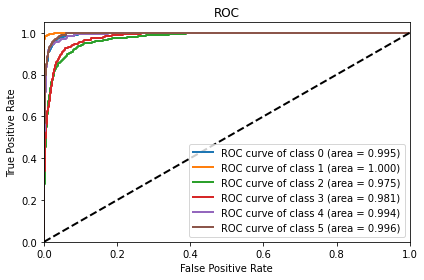

Evaluation ended
*******************************************************


In [9]:
label=MODELS[8]    
filepath='best_model_'+label
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print('*********************************************************')
print('Evalauatio and training with the pre trained model : ', label)
model=create_model(label)
hist = model.fit(train, epochs=20,
                     batch_size=32, validation_batch_size=32,
            validation_data=validation,
                     callbacks=callbacks_list
             )
test_score = model.evaluate(X_test, Y_test)
   
actual, predicted, Y_pred=generate_actual_predicted_y(model, X_test, Y_test)
print(test_score[0], test_score[1] * 100)
res=get_matrics(actual,predicted)
print("precision ", res[0])
print("recall ",res[1])
print("F1-Score ",res[2])
print("accuracy ",res[4])
print("Confusion matrix ", res[3])
plot_history(hist,label)
plot_roc(Y_test,Y_pred)
print('Evaluation ended')
print('*******************************************************')

**Summary**  
**With cross validation**

                avg f1, best f1
                
InceptionV3 : 0.8854750712662938 , 0.8942028434762729


MobileNetV2 : 0.8954336138802169,  0.9066779162081732


NASNetMobile: 0.891887001357885 ,  0.9055412525107269


Xception:     0.900477708117332 ,  0.9091226030905059


DenseNet169:  **0.900638267237721**,   0.9037009378020464


VGG19 :       0.8428994558935354,  0.8530634833615895


MobileNet:    0.8530634833615895,  **0.9113534787592522**



**Without cross validation**


              f1 score after 20 spochs
              
              
InceptionV3 : 0.8887247298534362


MobileNetV2 : 0.9006831220815906


NASNetMobile: 0.9048179894824694


Xception:     0.9040688007754626


DenseNet169:  **0.9088585007407161**


VGG19 :       0.8563531326657069 : after 5 epochs


MobileNet:    0.9055055450546102

We can see that Dense Net performed best in both. Moreover, The best f1 score was0.9111 for one of the MobileNet folds
Overall, Almost all of the models performed within the range of 0.88 to 0.9006 with the exception of VGG19 and mobileNet average f1 score. It is also north noticing that Mobile Net had the second lowest average and the hihgest f1 at the same time with cross validation. This is an indicator that the models might vary a lot when initialized. Thus cross validation is important to ensure consistenct results.
 
 
 In all the models, we can see class 2 and 3 were being confused a lot and they had the lowest roc curves and f1 scores. Perhaps cleaning the dataset will help to increase the performance. Finally, fine tuning DenseNet might increase its accuracy as it is the best model according to the f1 results. 
